# Coding assessment for Clinical Computational Cancer Genomics
## Author: Ian Snyder 
## Instructor/Lead: Dr. Saud AlDubayan

**Assigned: April 1, 2023**
**Due: April 10, 2023**

### Overall question: Can you discover any mutations that are associated with treatment response??

### [Step 0] Import Neccessary Modules

In [62]:
#Python Modules: 

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import seaborn as sns
sns.set_theme()
plt.rcParams.update({'font.size': 22})


### Task 1: Load Patient Data


Data will be read into two seperate dataframes: patientDf, which is indexed by patient, and aggDf, which is concatenated patient data.

In [63]:
class GetData(object):
    def __init__(self, path):
        self.path = path
        allfiles = [f for f in os.listdir(path) if f.endswith('.maf')]
        data = self.read_data(allfiles)
        self.patientDf = data[0]
        self.aggDf = data[1]

    def read_data(self, files: list):
        path = self.path + '/'
        Patients = {}
        allPatients = []
        for patient in files:
            patientId = patient.split('.')[0]
            patientDf = pd.read_table(path+patient)
            allpatDf = pd.read_table(path+patient, header=0, index_col=None)
            allPatients.append(allpatDf)
            Patients[patientId] = patientDf
        aggDf = pd.concat(allPatients, ignore_index=True)
        return (Patients, aggDf)


data = GetData('data/mafs')
patientDf = data.patientDf
aggDf = data.aggDf

aggDf.head()

,Hugo_Symbol,Chromosome,Start_position,End_position,Variant_Classification,Variant_Type,Reference_Allele,Tumor_Seq_Allele1,Tumor_Seq_Allele2,Tumor_Sample_Barcode,Matched_Norm_Sample_Barcode,Protein_Change,t_alt_count,t_ref_count
0,CEP350,1,180063656,180063656,Missense_Mutation,SNP,G,G,A,Patient-36-Tumor,Patient-36-Normal,p.E2806K,12,28
1,CCDC88C,14,91739009,91739009,Missense_Mutation,SNP,C,C,T,Patient-36-Tumor,Patient-36-Normal,p.G2016E,36,57
2,KDM6B,17,7749509,7749509,Missense_Mutation,SNP,A,A,T,Patient-36-Tumor,Patient-36-Normal,p.Y117F,4,25
3,PGAP1,2,197781268,197781268,Missense_Mutation,SNP,G,G,C,Patient-36-Tumor,Patient-36-Normal,p.F117L,11,25
4,PARD6B,20,49366765,49366765,Missense_Mutation,SNP,G,G,C,Patient-36-Tumor,Patient-36-Normal,p.E287Q,21,88


### Task 2: Subset for mutations that are not of the Variant Classification “Silent”


For the purposes of this analysis, we will restrict ourselves to substitutions which result in changes
to the produced protein (“nonsynonymous mutations”).

In [64]:
#subset aggdata
condition = aggDf['Variant_Classification'] != 'Silent'
aggSubset = aggDf[condition]
#Do the same for each patient
subsetDf = {}
for patient, patientDf in patientDf.items():
    condition = patientDf['Variant_Classification'] != 'Silent'
    df_subset = patientDf[condition]
    subsetDf[patient] = df_subset 
#Rassign global var to new subset
patientDf=subsetDf
aggDf = aggSubset

aggDf.head()

,Hugo_Symbol,Chromosome,Start_position,End_position,Variant_Classification,Variant_Type,Reference_Allele,Tumor_Seq_Allele1,Tumor_Seq_Allele2,Tumor_Sample_Barcode,Matched_Norm_Sample_Barcode,Protein_Change,t_alt_count,t_ref_count
0,CEP350,1,180063656,180063656,Missense_Mutation,SNP,G,G,A,Patient-36-Tumor,Patient-36-Normal,p.E2806K,12,28
1,CCDC88C,14,91739009,91739009,Missense_Mutation,SNP,C,C,T,Patient-36-Tumor,Patient-36-Normal,p.G2016E,36,57
2,KDM6B,17,7749509,7749509,Missense_Mutation,SNP,A,A,T,Patient-36-Tumor,Patient-36-Normal,p.Y117F,4,25
3,PGAP1,2,197781268,197781268,Missense_Mutation,SNP,G,G,C,Patient-36-Tumor,Patient-36-Normal,p.F117L,11,25
4,PARD6B,20,49366765,49366765,Missense_Mutation,SNP,G,G,C,Patient-36-Tumor,Patient-36-Normal,p.E287Q,21,88


### Task 3: Find the 15 most common mutations.

Gene names are included in the column Hugo_Symbol and protein changes are stored in the column Protein_Change. 
**Tie Breaking:** No specified tie breaking metric was given so rankties are handled by computing average ranks.

In [65]:
#Relevant Data
aggDf_small = aggDf[['Hugo_Symbol', 'Protein_Change']].copy()
#Count Mutations
mutation_counts = aggDf_small.groupby(['Hugo_Symbol', 'Protein_Change']
                     ).size().reset_index(name='Count')

mutation_counts.sort_values(by=['Count'], ascending=False, inplace=True)
#Rank based on count
mutation_counts['Rank'] = mutation_counts['Count'].rank(
    method='average', ascending=False)

#Get top 15 ranks
top_mutations = mutation_counts[mutation_counts['Rank'] <= 15]

#With ties 
print("-------------- Top Mutations---------------")
print(top_mutations)



-------------- Top Mutations---------------
     Hugo_Symbol Protein_Change  Count  Rank
2869       ERBB4       p.S1289A     14   1.0
2858       ERBB3        p.H228Q      5   3.0
6897      PIK3CA        p.E545K      5   3.0
2868       ERBB4        p.Q707E      5   3.0
5205      MAP2K1         p.F53L      4   8.5
7961        RXRA        p.S330F      4   8.5
9782       TYRO3        p.L819M      4   8.5
2860       ERBB3         p.M91I      4   8.5
2865       ERBB4        p.E317K      4   8.5
3038      FAM47C        p.Q225E      4   8.5
4835   KRTAP4-11        p.L161V      4   8.5
9479        TP53        p.R248Q      4   8.5


### Task 4: Perform a statistical test to explore if any mutated genes are enriched in patients who either responded or not

#### Task 4.1: Seperate patient genomic mutation data by response type

In [66]:

#Read patiend id info
PatientResponses = pd.read_table('data/sample-information.tsv')
#Get response type
PatientResponses_small = PatientResponses[['Patient_ID', 'Response']].copy()
#Parse patient data by response
responders = []
nonResponders = []
#Df Only containing UNIQUE genes per patient, this graph was dropped from final report
r1 = []
r2 = []
for row in PatientResponses_small.itertuples(index=False):
    c = patientDf.get(row[0]).copy()
    c.drop_duplicates(subset=['Hugo_Symbol'],inplace=True)
    if row[1]=='Non-Responder':
        r2.append(c)
        nonResponders.append(patientDf.get(row[0]))
    else:
        r1.append(c)
        responders.append(patientDf.get(row[0])) 

#CHECK COUNT OF EACH ENSURE SAME
print(f'Number of responders: {len(responders)}')
print(f'Number of Non_responders: {len(nonResponders)}')




Number of responders: 25
Number of Non_responders: 25


Sample size is the same for each sample type, which is important to consider when deciding statistical approach / how to interpret results. 

#### Task 4.2: Chi Square Test

First thing to consider is are the two groups significantly different with respect to gene frequencies across all genes. Ensuring the frequencies as a whole are not significantly different between groups is important to consider when trying to determine individually significant frequencies. If the response groups are not significantly different then individually obscure frequency differences are more likely to be significant.

In [67]:
#Concat databases
respondersDf = pd.concat(responders, ignore_index=True)
nonRespondersDf = pd.concat(nonResponders, ignore_index=True)
responders_count = respondersDf.groupby(
    'Hugo_Symbol').size().reset_index(name='Count')
non_responders_count = nonRespondersDf.groupby(
    'Hugo_Symbol').size().reset_index(name='Count')


# Merge the two DataFrames on 'Hugo_Symbol'
merged_df = pd.merge(responders_count, non_responders_count,
                     on='Hugo_Symbol', suffixes=('_responders', '_non_responders'))

contingency_table = merged_df[[
    'Count_responders', 'Count_non_responders']].to_numpy()

# Perform the Chi-Square test two ensure overall distribution is similar
chi2, p_value, _, _ = chi2_contingency(contingency_table)

print(f"Chi-Square statistic: {chi2}")
print(f"P-value: {p_value}")


Chi-Square statistic: 368.85665453419114
P-value: 1.0


A P-value of 1.0 validates the assertion that there is no significant differences between response type with respect to gene frequencies.

#### Task 4.3 Identify individual genes with the largest frequency difference between groups

Individual frequency differences were calculated across all genes, and was normalized using absolute value. When trying to determine individually significant differences, the method used involves calculating the mean and standard deviation of differences to construct a 99.9% Confidence Interval. The upper bound of the Confidence Interval will represent the critical value used to determine enriched genes. Frequencies greater than the upper bound represent the 0.1 percentile of largest differences. The genes pertaining to those differences are plotted in decending order with respect to frequency.

Mean difference: 0.7454394693200663
Standard Deviation of difference: 1.205399304402897
Upper Bound 99.9% CI: 4.71240858011


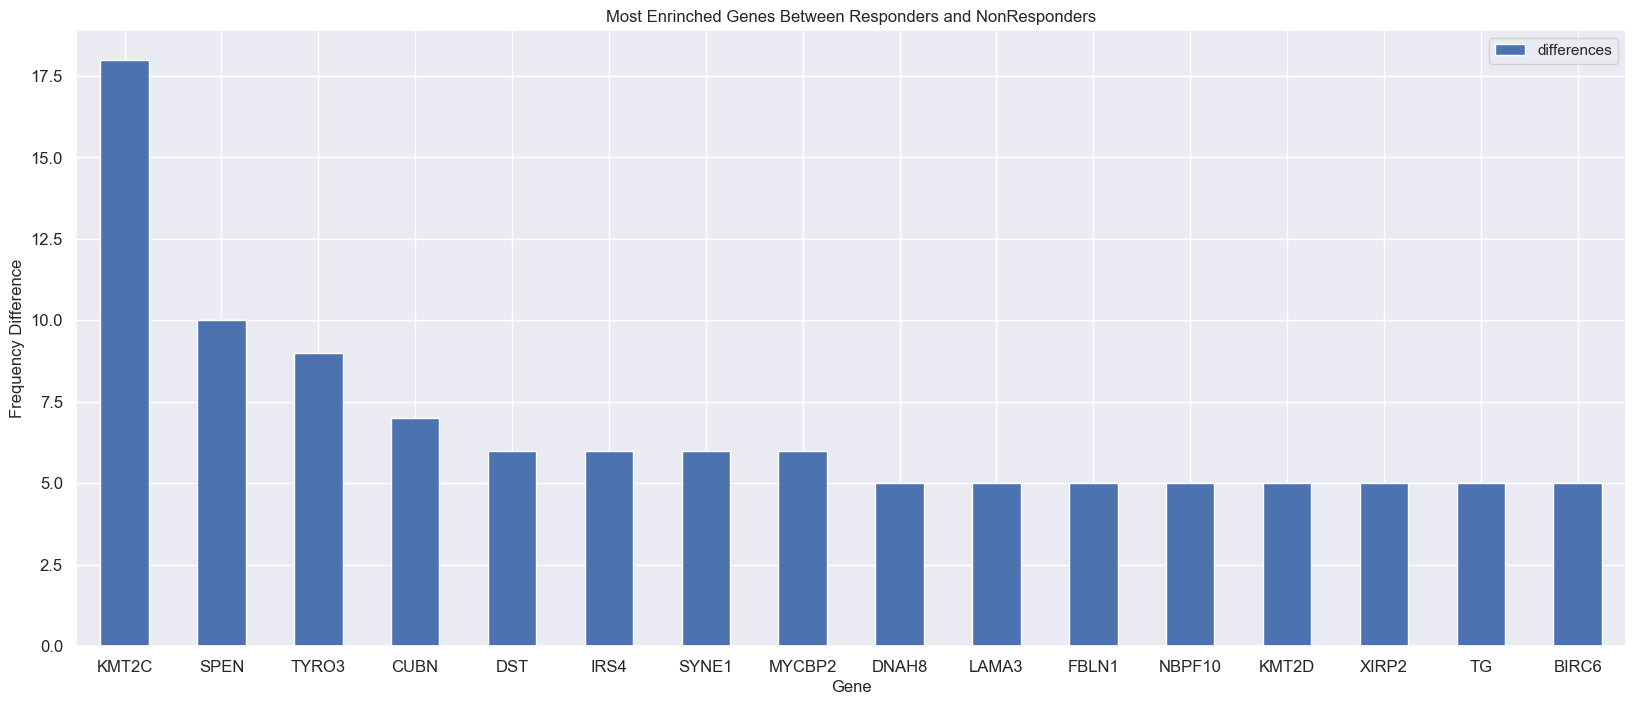

In [68]:
#Calculate differences between response
merged_df['differences'] = merged_df['Count_responders'] - merged_df['Count_non_responders']
merged_df['differences'] = merged_df['differences'].abs()

#Get average to help determine significantly different values
mean = merged_df['differences'].mean()
std = merged_df['differences'].std()
CRITICAL_VALUE = mean + (3.291*std)

print(f'Mean difference: {mean}')
print(f'Standard Deviation of difference: {std}')
print(f'Upper Bound 99.9% CI: {CRITICAL_VALUE}')


#Sort results
merged_df.sort_values(by=['differences'], ascending=False, inplace=True)

# Get results above crit value
sigDf = merged_df[merged_df['differences'] >  CRITICAL_VALUE]

#Display
sigDf.plot.bar(x='Hugo_Symbol', y='differences', rot=0, figsize=(20, 8), title='Most Enrinched Genes Between Responders and NonResponders',
               fontsize=12, xlabel='Gene', ylabel='Frequency Difference')



We can clearly observe the gene KMT2C stands out even amongst the top 0.1 percentile. Lets seperate the graph by response type to get insight into which genes are enriched in which group.

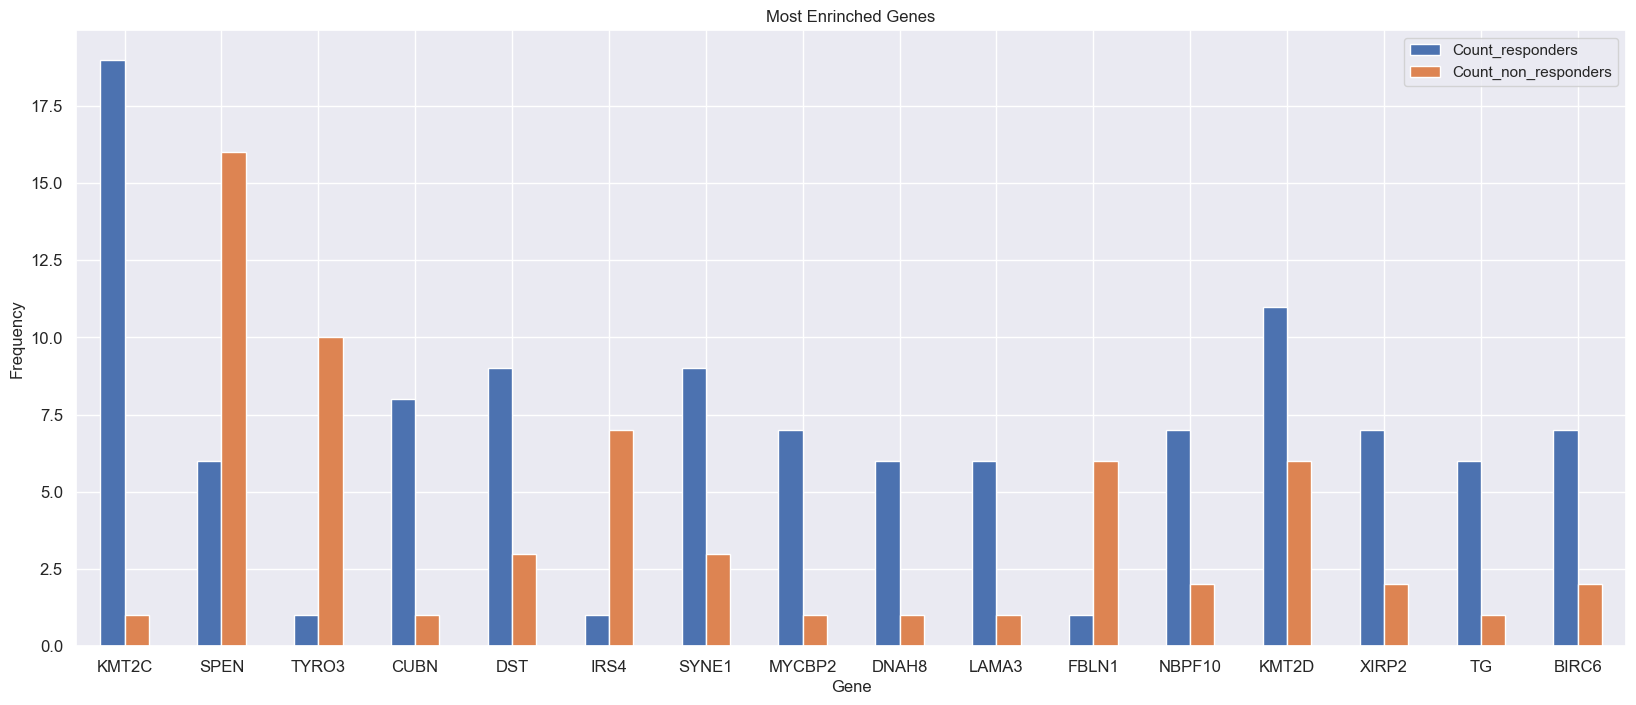

In [69]:
curDf = sigDf.copy()
curDf.plot.bar(x='Hugo_Symbol', y=['Count_responders','Count_non_responders'], rot=0, figsize=(20, 8), title='Most Enrinched Genes',
               fontsize=12, xlabel='Gene', ylabel='Frequency')


We can see the KMT2C gene is enriched in the response group, and the SPEN gene is most enriched in the non-response group. The KMT2C gene still stands out as the most significant.

### Task 5: Create a scatter plot of genes with the number of mutated patients

The number of mutated patients on the x-axis and the results from task 4 on the y-axis.

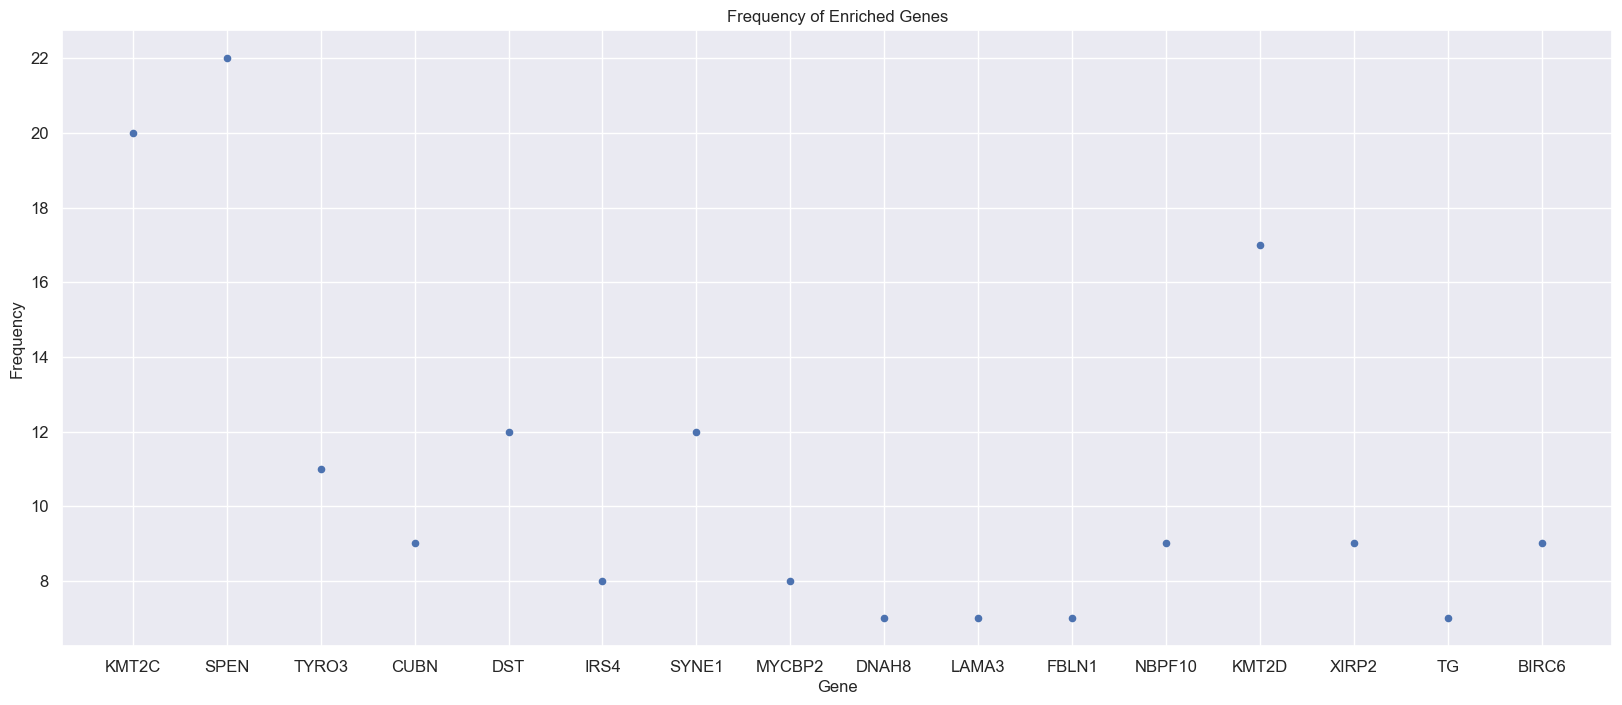

In [70]:
#Get total counts
curDf = sigDf.copy()
curDf['total'] = sigDf['Count_responders'] + sigDf['Count_non_responders']
#Scatter Plot

curDf.plot.scatter(x='Hugo_Symbol', y='total', rot=0, figsize=(20, 8), title='Frequency of Enriched Genes',
                    fontsize=12, xlabel='Gene', ylabel='Frequency')



#### Task 5.1: Improve readability of Task 5


A bar plot provides a very readable form for the data.

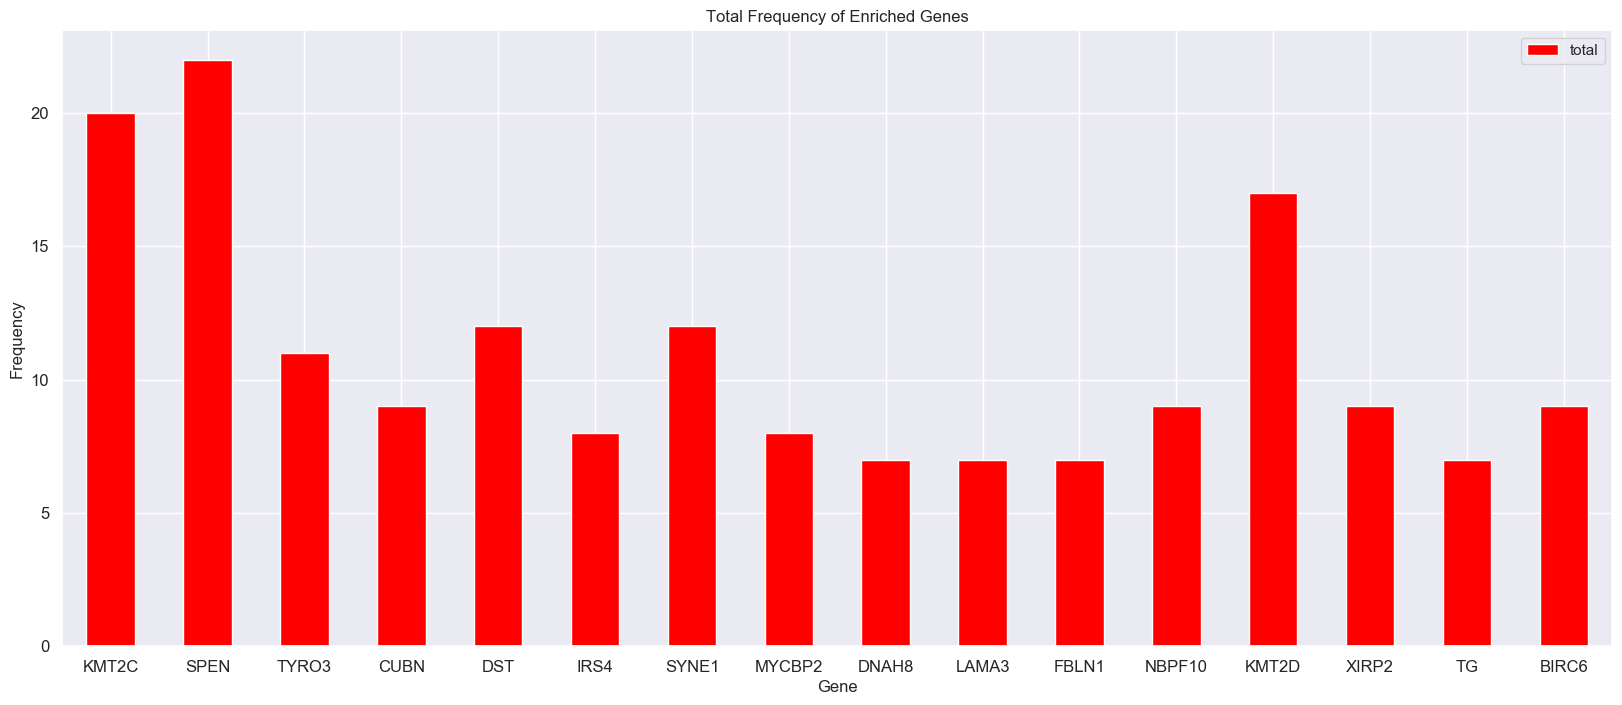

In [71]:
#Much more readable version

curDf.plot.bar(x='Hugo_Symbol', y='total', rot=0, figsize=(20, 8), title='Total Frequency of Enriched Genes',
               fontsize=12, xlabel='Gene', ylabel='Frequency', color='red')


The results are expected. The general trend is data that had higher difference values had higher total values.

### Task 6: Wild-type versus mutant with respect to the most significantly enriched gene

#### Task 6.1: How many samples are wild-type versus mutant

In [72]:
#Get significant gene
gene = sigDf['Hugo_Symbol'].iloc[0]

print(f'Hugo_Symbol for most enriched gene:{gene}')

#get Nonsynonymous data, parse by patient id
PatientResponses_small = PatientResponses[[
    'Patient_ID', 'Nonsynonymous_mutations_per_Mb']].copy()
NonsynonymousVals = dict(zip(PatientResponses_small.Patient_ID,
                   PatientResponses_small.Nonsynonymous_mutations_per_Mb))

#Get sums and patient ids who have gene
wildtype = []
wildtypeSum = 0
mutantSum = 0
mutant = []
for keys,values in patientDf.items():
    if gene in values['Hugo_Symbol'].values:
        mutant.append(keys)
        mutantSum += NonsynonymousVals.get(keys)
    else:
        wildtype.append(keys)
        wildtypeSum += NonsynonymousVals.get(keys)
    
#Very interesting
print(f'Number of wildtype patients: {len(wildtype)}')
print(f'Number of mutant patients: {len(mutant)}')


print(f'Average Nonsynonymous Mutations per Mb for  wildtype patient: {wildtypeSum/len(wildtype)}')
print(
    f'Average Nonsynonymous Mutations per Mb for  mutant patient: {mutantSum/len(mutant)}')





Hugo_Symbol for most enriched gene:KMT2C
Number of wildtype patients: 42
Number of mutant patients: 8
Average Nonsynonymous Mutations per Mb for  wildtype patient: 5.419761904761906
Average Nonsynonymous Mutations per Mb for  mutant patient: 9.46


#### Task 6.2: Plot the number of nonsynonymous mutations per megabase in the mutant vs. wild-type samples.

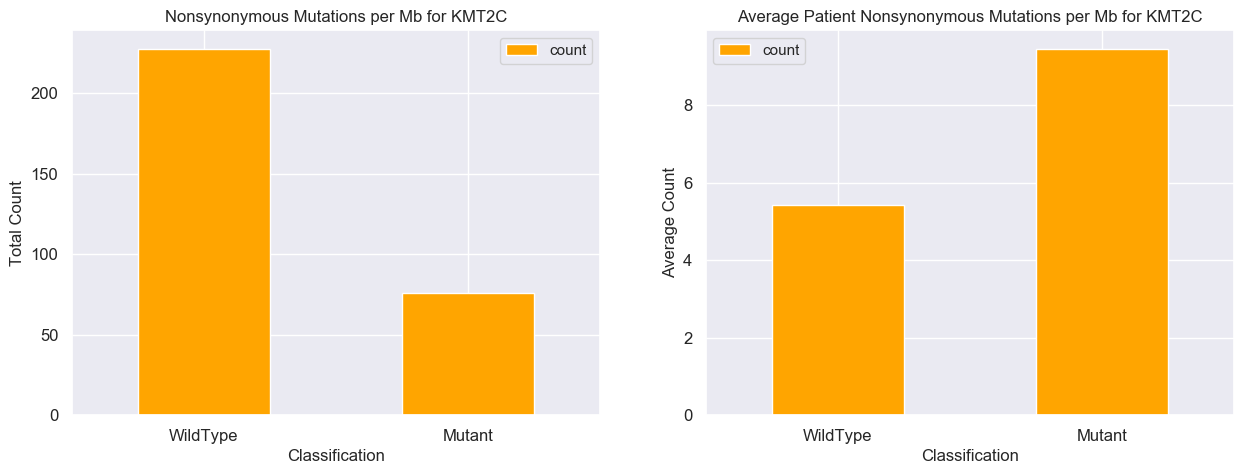

In [73]:
#Plot results
totalDf = pd.DataFrame(
    {'type': ['WildType', 'Mutant'], 'count': [wildtypeSum, mutantSum]})
perDf = pd.DataFrame(
    {'type': ['WildType', 'Mutant'], 'count': [wildtypeSum/len(wildtype), mutantSum/len(mutant)]})
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 5))
totalDf.plot.bar(x='type', y='count', rot=0, figsize=(7,5),
                    title=f'Nonsynonymous Mutations per Mb for {gene}', ylabel='Total Count', xlabel='Classification', fontsize=12, color='orange', ax=ax1)

perDf.plot.bar(x='type', y='count', rot=0, figsize=(15, 5),
                 title=f'Average Patient Nonsynonymous Mutations per Mb for {gene}', ylabel='Average Count', xlabel='Classification', fontsize=12, color='orange', ax=ax2)



#### Task 6.3: Is there a significant difference in the number of mutations between the two groups?

Firstly, its very interesting to notice the number of patients who contain the significant gene KMT2C is very low, only 8 patients had it which might suggest certain patients have some trait that makes them susceptible to mutations at this gene.
To answer the question, there is a significant difference in the number of mutations per group, but it is important to note the size of the mutant group is about one fifth the size of the wildtype. When looking at the average nonsynonymous mutations per megabase per patient, the value in the mutant group is about twice as much. 
Essentially, the total values suggest wildtype has more nonsynonymous mutations per megabase, but when considering sample unit, mutants have twice as much nonsynonymous mutations per megabase.


## Conclusion 
The results from this analysis suggest there are genes associated with treatment response, specifically the gene KMT2C. However, a sample size of 50 is not large enough to draw any major conclusions, but this study suggests it could be worth investigating further. One of the big issues with small sample sizes is that individuals who dont represent the true population can influence the data dramatically leading to false conclusions.
In this study specifically, the frequency of the most enriched gene KMT2C was 20. Patient-38 had 12 mutations on this gene specifically, meaning this indivudal skewed the data tremendously. We have no idea what stage of cancer they were in, or what previous exposures they had that may promoted mutations at that gene. A larger dataset would allow a much more compelling analysis, as larger data decreases the individuals weight in statistical analysis. It is worth noting, even when only considering unique genes per patient, the gene KMT2C was still identified as the clear most enriched gene.  
Overall, this study suggests the gene KMT2C may be associated with treatment response. However, it would be unresponsible to ignore the factors mentioned above before asserting the claim as conclusive.
